In [69]:
%matplotlib inline

import sys
import os
import json
from glob import glob
from collections import defaultdict, OrderedDict

import dinopy
import yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn
import numpy
import pandas as pd
import networkx
from scipy.special import binom
from scipy import stats
from IPython.display import Image, display

from phasm.io import gfa
from phasm.alignments import AlignmentType
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style('whitegrid')

In [13]:
spanning_read_stats = []
candidate_prob_stats = []
bubble_map = defaultdict(dict)
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    for debugdata in glob("{}/04_phase/component[0-9].bubblechain[0-9]-debugdata.json".format(asm_folder)):
        print(debugdata)
        graphml = debugdata.replace("04_phase", "03_chain").replace("-debugdata.json", ".graphml")
        g = AssemblyGraph(networkx.read_graphml(graphml))
        
        curr_bubble = None
        bubble_num = 0
        num_candidates = -1
        with open(debugdata) as f:
            for line in f:
                data = json.loads(line)
                if data['type'] == "new_bubble":
                    curr_bubble = data
                    bubble_map[ploidy, coverage][(data['entrance'], data['exit'])] = data
                    
                    if data['start_of_block'] == True:
                        bubble_num = 1
                    else:
                        dist_between_bubbles = (
                            min(e[2] for e in g.out_edges_iter(data['entrance'], data=g.edge_len))
                        )
                        spanning_read_stats.append({
                            'dist': dist_between_bubbles,
                            'spanning_reads': len(data['rel_read_info']),
                            'ploidy': ploidy
                        })
                        
                        bubble_num += 1
                
                if data['type'] == "candidate_set":
                    p_sr = data['p_sr']
                    prior = data['prior']
                    prob = 10**(p_sr + prior)
                    entrance = curr_bubble['entrance']
                    exit = curr_bubble['exit']
                    candidate_prob_stats.append({
                        'bubble': (entrance, exit),
                        'bubble_num': bubble_num,
                        'candidate_prob': prob,
                        'ploidy': ploidy,
                        'coverage': coverage
                    })

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/component1.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/04_phase/component1.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy4-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy4-60x-error-free/04_phase/component1.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy6-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy6-60x-error-free/

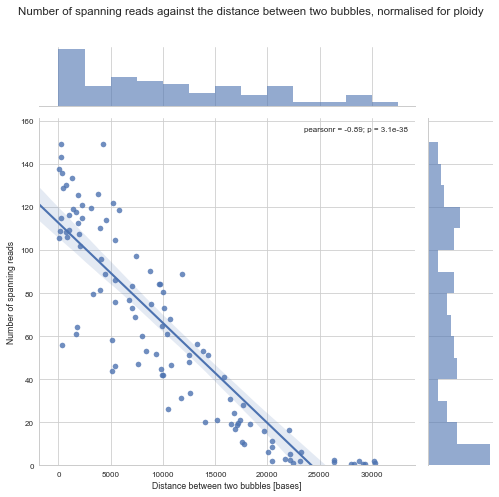

In [70]:
srdf = pd.DataFrame(spanning_read_stats)
srdf['spanning_reads_norm'] = srdf['spanning_reads'] / srdf['ploidy']
g = seaborn.JointGrid(x="dist", y="spanning_reads_norm", data=srdf, size=7)
x_bin_size = 2500
g.ax_marg_x.hist(srdf['dist'], alpha=0.6, bins=numpy.arange(0, srdf['dist'].max()+x_bin_size, x_bin_size))
y_bin_size = 10
g.ax_marg_y.hist(srdf['spanning_reads_norm'], alpha=0.6, orientation="horizontal",
                 bins=numpy.arange(0, srdf['spanning_reads_norm'].max()+y_bin_size, y_bin_size))
g.plot_joint(seaborn.regplot)
g.annotate(stats.pearsonr)

seaborn.plt.suptitle("Number of spanning reads against the distance between two bubbles, normalised for ploidy")
plt.ylim(ymin=0)
plt.xlabel("Distance between two bubbles [bases]")
plt.ylabel("Number of spanning reads")
plt.subplots_adjust(top=0.9)
plt.savefig(os.path.join(BASE_DIR, 'figures', 'spanning-reads.png'), transparent=True, dpi=256)



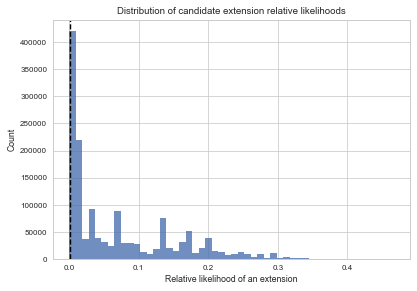

In [74]:
candidate_df = pd.DataFrame(candidate_prob_stats)
candidate_df.set_index('bubble')
plt.figure()
seaborn.distplot(candidate_df['candidate_prob'], kde=False, hist_kws={"alpha": 0.8})
plt.title("Distribution of candidate extension relative likelihoods")
plt.xlabel("Relative likelihood of an extension")
plt.ylabel("Count")
# plt.xlim(xmax=1.0)
plt.axvline(1e-3, linestyle='--', color='black')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'rel-likelihood-abs.png'), transparent=True, dpi=256)

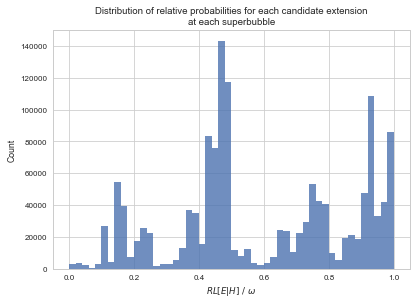

In [77]:
grouped = candidate_df.groupby(['bubble', 'ploidy'])['candidate_prob']
max_probs = grouped.max()

for bubble, ploidy in grouped.groups.keys():
    candidate_df.loc[grouped.groups[bubble, ploidy], 'max_prob'] = max_probs[bubble, ploidy]
    
candidate_df['relative_prob'] = candidate_df['candidate_prob'] / candidate_df['max_prob']
candidate_df

plt.figure()
seaborn.distplot(candidate_df[candidate_df['relative_prob'] < 1.0]['relative_prob'], kde=False, hist_kws={"alpha": 0.8})
plt.title("Distribution of relative probabilities for each candidate extension\n"
          "at each superbubble")
plt.xlabel(r"$RL[E|H]\ /\ \omega$")
plt.ylabel("Count")
plt.savefig(os.path.join(BASE_DIR, "figures", "rl-relative-dist.png"), transparent=True, dpi=256)

In [31]:
c1, c2, c3, c4, c5 = seaborn.color_palette(n_colors=5)
pruning_stats = []

for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    if coverage != 60:
        continue
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    for chain_num, graphml in enumerate(glob("{}/03_chain/component[0-9].bubblechain[0-9].graphml".format(asm_folder))):
        print(graphml)
        
        # Calculate effect of pruning
        g = AssemblyGraph(networkx.read_graphml(graphml))
        
        bubbles = OrderedDict(find_superbubbles(g, report_nested=False))
        bubble_num = 0
        for i, bubble in enumerate(reversed(bubbles.items())):
            entrance, exit = bubble
            num_paths = len(list(networkx.all_simple_paths(g, entrance, exit)))
            
            if not bubble in bubble_map[ploidy, coverage]:
                continue
                
            bubble_data = bubble_map[ploidy, coverage][bubble]
            if bubble_data['start_of_block']:
                bubble_num = 1
            else:
                bubble_num += 1
                
            kappa = 0.0
            pruned = 0
            num_candidates_left = sys.maxsize
            while num_candidates_left > 500 and kappa < 1.0:
                kappa += 0.1
                num_candidates_left = len(
                    candidate_df.query('(bubble == @bubble) and (ploidy == @ploidy) and (relative_prob >= @kappa)')
                )
                pruned = len(
                    candidate_df.query('(bubble == @bubble) and (ploidy == @ploidy) and (relative_prob < @kappa)')
                )
                
            pruning_stats.append({
                'ploidy': ploidy,
                'coverage': coverage,
                'bubble_num': bubble_num,
                'pruned': pruned,
                'kappa': kappa
            })
        

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/03_chain/component0.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/03_chain/component1.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/03_chain/component0.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/03_chain/component1.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy4-60x-error-free/03_chain/component0.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy4-60x-error-free/03_chain/component1.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy6-60x-error-free/03_chain/component0.bubblechain0.graphml
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy6-60x-error-free/03_chain/component1.bubblechain0.graphml
/run/med

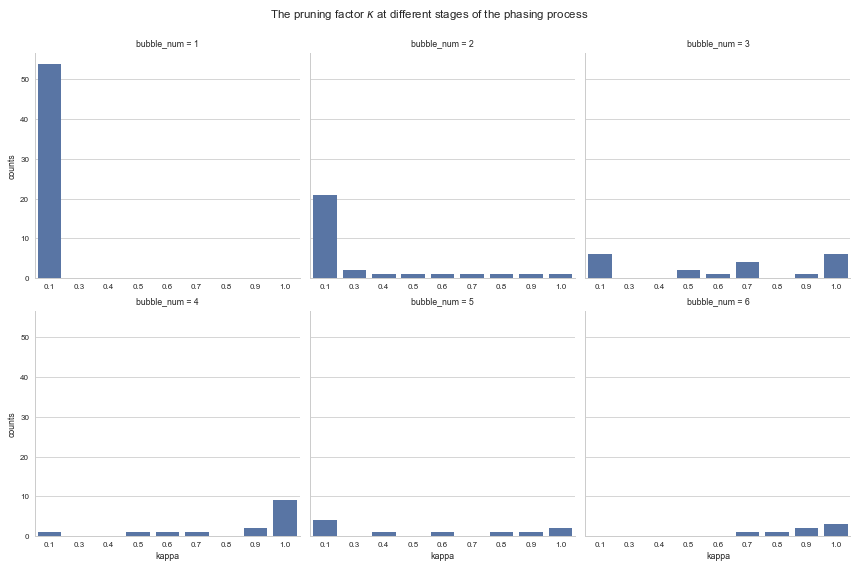

In [42]:
pruning_df = pd.DataFrame(pruning_stats)
agg_df = pd.DataFrame(pruning_df.groupby(['bubble_num', 'kappa']).size().rename('counts'))
agg_df.reset_index(level=agg_df.index.names, inplace=True)

seaborn.factorplot(x="kappa", y="counts", col="bubble_num", 
                   kind="bar", col_wrap=3, sharex=False, color=c1,
                   data=agg_df.query('(bubble_num < 7) and (kappa <= 1.0)'))
seaborn.plt.suptitle('The pruning factor $\kappa$ at different stages of the phasing process')
plt.subplots_adjust(top=0.9)
plt.savefig(os.path.join(BASE_DIR, 'figures', 'pruning.png'), transparent=True, dpi=256)